In [1]:
import sys
import os

sys.path.append('/om2/user/msaddler/python-packages/bez2018model')
from bez2018model_run_hdf5_dataset import bez2018model
import importlib
importlib.reload(bez2018model)

sys.path.append('/om4/group/mcdermott/user/msaddler/pitchnet_dataset/pitchnetDataset/pitchnetDataset')
import dataset_util
import augment_dataset

import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import IPython.display as ipd

import scipy.signal
import scipy.io.wavfile


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


ImportError in `dataset_util.py` No module named 'pyfftw'


In [2]:
kwargs_nervegram_meanrates = {
    'meanrates_params': {
        'dur': 0.050,
        'fs':20e3,
        'buffer_start_dur': 0.07,
        'buffer_end_dur': 0.01,
    },
    'ANmodel_params': {
        'num_cfs': 100,
        'min_cf':125,
        'max_cf':14e3,
        'spont_list':[70.0],
        'cohc':1.0,
        'bandwidth_scale_factor':1.0,
        'IhcLowPass_cutoff': 250.0,
        'IhcLowPass_order': 7,
    },
}


sr = 32000
t = np.arange(0, 0.150, 1/sr)
signal = np.zeros_like(t)
noise = np.random.randn(signal.shape[0])
f0 = 200
phase_mode = 'sine'
spectral_region = 'none'

freq_list = f0*np.arange(1, 60)

if phase_mode == 'alt':
    phase_list = np.pi/2 * np.ones(len(freq_list))
    phase_list[::2] = 0
else:
    phase_list = np.zeros(len(freq_list))

for freq, phase in zip(freq_list, phase_list):
    if freq < sr/2:
        signal = signal + np.sin(2*np.pi*freq*t + phase)


if spectral_region == 'low':
    signal = augment_dataset.apply_butterworth_filter(signal, sr, 1, [125, 625], 'bandpass', filtfilt=True)
elif spectral_region == 'high':
    signal = augment_dataset.apply_butterworth_filter(signal, sr, 1, [3900, 5400], 'bandpass', filtfilt=True)
elif spectral_region == 'custom':
    signal = augment_dataset.apply_butterworth_filter(signal, sr, 1, [1e2, 1e4], 'bandpass', filtfilt=True)


snr = 12
dBSPL = 60
noise = np.random.randn(noise.shape[0])

y = dataset_util.combine_signal_and_noise(signal, noise, snr=snr,
                                          rms_out=20e-6*np.power(10, dBSPL/20))
# y = signal
print(signal.shape, noise.shape, y.shape)

ipd.display(ipd.Audio(y, rate=sr))

# out_dict = bez2018model.nervegram_meanrates(y, sr, **kwargs_nervegram_meanrates)



(4800,) (4800,) (4800,)


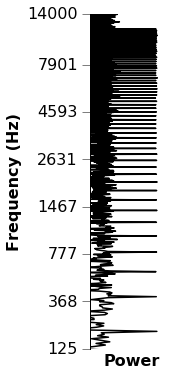

In [15]:
def freq2erb(freq):
    return 21.4 * np.log10(0.00437 * freq + 1.0)

def erb2freq(erb):
    return (1.0/0.00437) * (10.0 ** (erb / 21.4) - 1.0)


fontsize=16

yticks = np.array([125, 368, 777, 1467, 2631, 4593, 7901, 14000])
yticks_erb = freq2erb(yticks)

fxx, pxx = dataset_util.power_spectrum(y, sr)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(1.5, 6))

ax.plot(pxx, freq2erb(fxx), 'k', lw=1.5)
ax.set_xlim([-5, 40])
ax.set_xticks([])
ax.set_ylim([yticks_erb[0], yticks_erb[-1]])
ax.set_yticks(yticks_erb)
ax.set_yticklabels(yticks, fontsize=fontsize)
ax.set_ylabel('Frequency (Hz)', fontsize=fontsize, fontweight='bold')
ax.set_xlabel('Power', fontsize=fontsize, fontweight='bold')

ax.tick_params(direction='out', axis='both', which='major', length=8, right=True, top=True)
ax.tick_params(direction='out', axis='both', which='minor', length=8, right=True, top=True)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
# ax.spines["left"].set_visible(False)

plt.show()

# save_dirname = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures'
# save_basename = 'tmp_spectrum_sideways_200HzF0_erb_scale.pdf'
# fig.savefig(os.path.join(save_dirname, save_basename), bbox_inches='tight')


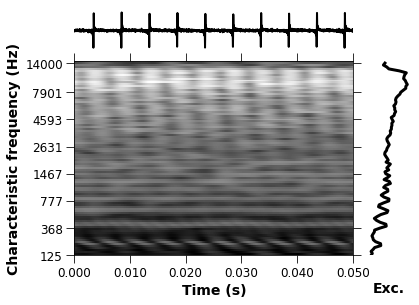

In [46]:
def make_plot(pin_fs, pin, mr_fs, mr, freq,
              figsize=(12, 8),
              xfont=22, yfont=22, tickfont=18,
              min_time=None, max_time=None,
              lw_stimulus=2,
              lw_excitation=4):
    pin = np.squeeze(pin)
    mr = np.squeeze(mr)

    pin_time = np.arange(0, pin.shape[0]) / pin_fs
    mr_time = np.arange(0, mr.shape[1]) / mr_fs
    if (not min_time == None) and (not max_time == None):
        pin_idx = np.squeeze(np.argwhere(np.logical_and(pin_time>=min_time, pin_time<=max_time)))
        mr_idx = np.squeeze(np.argwhere(np.logical_and(mr_time>=min_time, mr_time<=max_time)))
        pin_time = pin_time[pin_idx]
        pin = pin[pin_idx]
        mr_time = mr_time[mr_idx]
        mr = mr[:, mr_idx]

    freq = np.array(freq)
    freq_idx = np.linspace(0, freq.shape[0]-1, 8, dtype=int)
    freq_labels = ['{:.0f}'.format(freq[itr0]) for itr0 in freq_idx]
    time_idx = np.linspace(0, mr_time.shape[0]-1, 6, dtype=int)
    time_labels = ['{:.3f}'.format(mr_time[itr0]) for itr0 in time_idx]

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize,
                           gridspec_kw={'height_ratios':[1,5], 'width_ratios':[7,1], 'hspace':0.1, 'wspace':0.1},
                           sharex=False)
    
    ax[0,0].plot(pin_time, pin, 'k-', lw=lw_stimulus)
    ax[0,0].set_xlim([pin_time[0], pin_time[-1]])
    ax[0,0].set_yticks([])
    ax[0,0].set_yticklabels([])
    ax[0,0].get_xaxis().set_visible(False)
    ax[0,0].get_yaxis().set_visible(False)
    ax[0,0].spines["top"].set_visible(False)
    ax[0,0].spines["right"].set_visible(False)
    ax[0,0].spines["bottom"].set_visible(False)
    ax[0,0].spines["left"].set_visible(False)

    ax[1,0].imshow(mr, origin='lower', aspect='auto', extent=[0, mr.shape[1], 0, mr.shape[0]], cmap=cm.gray)
    ax[1,0].set_yticks(freq_idx)
    ax[1,0].set_yticklabels(freq_labels, fontsize=tickfont)
    ax[1,0].set_xticks(time_idx)
    ax[1,0].set_xticklabels(time_labels, fontsize=tickfont)
    ax[1,0].set_xlabel('Time (s)', fontsize=xfont, fontweight='bold')
    ax[1,0].set_ylabel('Characteristic frequency (Hz)', fontsize=yfont, fontweight='bold')
    ax[1,0].tick_params(axis='both', labelsize=tickfont)
    ax[1,0].tick_params(direction='out', axis='both', which='major', length=8, right=True, top=True)
    ax[1,0].tick_params(direction='out', axis='both', which='minor', length=8, right=True, top=True)

    ax[0,1].axis('off')
    
    ax[1,1].plot(np.sum(mr, axis=1), np.arange(0, mr.shape[0]), 'k', lw=lw_excitation)

    ax[1,1].set_xticks([])
    ax[1,1].set_yticks([])

    ax[1,1].spines["top"].set_visible(False)
    ax[1,1].spines["bottom"].set_visible(False)
    ax[1,1].spines["right"].set_visible(False)
    ax[1,1].spines["left"].set_visible(False)
    ax[1,1].set_ylim([0, mr.shape[0]])
    ax[1,1].set_xlabel('Exc.', fontsize=xfont, fontweight='bold', labelpad=tickfont+xfont)
#     ax[1,1].spines["bottom"].set_visible(False)
#     ax[1,1].spines["left"].set_visible(False)
    
    plt.show()
    
    return fig, ax


pin_fs = out_dict['pin_fs']
pin = out_dict['pin']
mr_fs = out_dict['meanrates_fs']
mr = out_dict['meanrates']
freq = out_dict['cf_list']
pin_fs = out_dict['pin_fs']
fig, ax = make_plot(pin_fs, pin, mr_fs, mr, freq, figsize=(6, 4.5),
                    xfont=14, yfont=14, tickfont=12,
                    min_time=None, max_time=None,
                    lw_stimulus=2, lw_excitation=3)

# save_dirname = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures'
# save_basename = 'tmp_nervegram_200HzF0_IHC0250Hz.pdf'
# fig.savefig(os.path.join(save_dirname, save_basename), bbox_inches='tight')


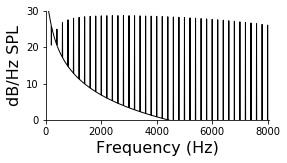

In [10]:
fontsize=16

fxx, pxx = dataset_util.power_spectrum(y, sr)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))
ax.plot(fxx, pxx, color='k', lw=1)

ax.set_xlim([0, 8050])
ax.set_ylim([0, 30])
ax.set_xlabel('Frequency (Hz)', fontsize=fontsize)
ax.set_ylabel('dB/Hz SPL', fontsize=fontsize)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

# save_dirname = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures'
# save_basename = 'tmp_spectrum_200HzF0_xlim8000Hz.pdf'
# fig.savefig(os.path.join(save_dirname, save_basename), bbox_inches='tight')


cf= 3091.2148


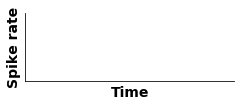

In [21]:

fontsize=14

fidx = 60#81
print('cf=', freq[fidx])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.75, 1.25))

mr_trace = mr[fidx, :, 0]
mr_time = np.arange(0, mr.shape[1]) / mr_fs

ax.plot(mr_time, mr_trace, color='k', lw=3)

ax.set_xlim([0.0275, 0.0475])
ax.set_xticks([])
ax.set_yticks([])
ax.set_yticklabels([])
ax.set_ylim([0, np.max(mr_trace)*1.5])
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#     ax.spines["bottom"].set_visible(False)
#     ax.spines["left"].set_visible(False)

ax.set_ylabel('Spike rate', fontsize=fontsize, fontweight='bold')
ax.set_xlabel('Time', fontsize=fontsize, fontweight='bold')
plt.show()



In [132]:
sr = 32000
t = np.arange(0, 0.150, 1/sr)
signal = np.zeros_like(t)
noise = np.random.randn(signal.shape[0])
f0 = 250
phase_mode = 'sine'
spectral_region = 'custom'

freq_list = f0*np.arange(1, 60)

if phase_mode == 'alt':
    phase_list = np.pi/2 * np.ones(len(freq_list))
    phase_list[::2] = 0
else:
    phase_list = np.zeros(len(freq_list))

for freq, phase in zip(freq_list, phase_list):
    if freq < sr/2:
        signal = signal + np.sin(2*np.pi*freq*t + phase)


if spectral_region == 'low':
    signal = augment_dataset.apply_butterworth_filter(signal, sr, 1, [125, 625], 'bandpass', filtfilt=True)
elif spectral_region == 'high':
    signal = augment_dataset.apply_butterworth_filter(signal, sr, 1, [3900, 5400], 'bandpass', filtfilt=True)
elif spectral_region == 'custom':
    signal = augment_dataset.apply_butterworth_filter(signal, sr, 1, [1e2, 1e4], 'bandpass', filtfilt=True)

# signal = np.sin(2*np.pi*5000*t)

snr = 100
dBSPL = 60
noise = np.random.randn(noise.shape[0])

y = dataset_util.combine_signal_and_noise(signal, noise, snr=snr,
                                          rms_out=20e-6*np.power(10, dBSPL/20))
# y = signal

ipd.display(ipd.Audio(y, rate=sr))

cf= 5000.0
cf= 5000.0
cf= 5000.0
cf= 5000.0


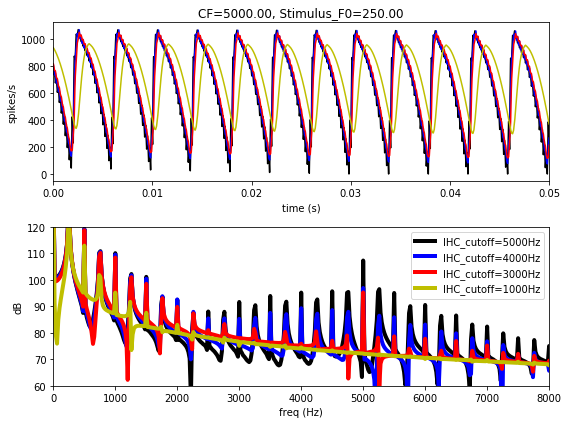

In [136]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

color_list = ['k', 'b', 'r', 'y']
for cidx, IHC_cutoff in enumerate([5e3, 4e3, 3e3, 1e3]):

    kwargs_nervegram_meanrates = {
        'meanrates_params': {
            'dur': 0.050,
            'fs':100e3,
            'buffer_start_dur': 0.07,
            'buffer_end_dur': 0.01,
        },
        'ANmodel_params': {
            'num_cfs': 1,
            'min_cf':5000,
            'max_cf':5000,
            'spont_list':[70.0],
            'cohc':1.0,
            'bandwidth_scale_factor':1.0,
            'IhcLowPass_cutoff': IHC_cutoff,
            'IhcLowPass_order': 7,
        },
    }

    np.random.seed(0)
    out_dict = bez2018model.nervegram_meanrates(y, sr, **kwargs_nervegram_meanrates)

    
    pin_fs = out_dict['pin_fs']
    pin = out_dict['pin']
    mr_fs = out_dict['meanrates_fs']
    mr = out_dict['meanrates']
    freq = out_dict['cf_list']
    pin_fs = out_dict['pin_fs']

    fidx = 0
    print('cf=', freq[fidx])

    mr_trace = mr[fidx, :, 0]
    mr_time = np.arange(0, mr.shape[1]) / mr_fs

    fxx, pxx = dataset_util.power_spectrum(mr_trace, mr_fs)

    ax[0].plot(mr_time, mr_trace, color=color_list[cidx])
    ax[1].plot(fxx, pxx, color=color_list[cidx], lw=4,
               label='IHC_cutoff={:.0f}Hz'.format(IHC_cutoff))
    
ax[0].set_xlim([mr_time[0], mr_time[-1]])
ax[0].set_ylabel('spikes/s')
ax[0].set_xlabel('time (s)')
ax[0].set_title('CF={:.2f}, Stimulus_F0={:.2f}'.format(freq[fidx], f0))
ax[1].legend(loc='upper right')

ax[1].set_xlim([0, 8e3])
ax[1].set_ylim([60, 120])
ax[1].set_ylabel('dB')
ax[1].set_xlabel('freq (Hz)')

plt.tight_layout()
plt.show()

cf= 5000.0


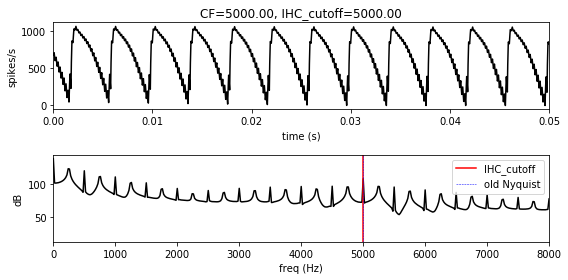

cf= 5000.0


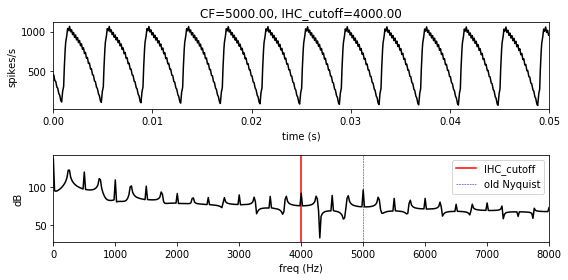

In [107]:
pin_fs = out_dict['pin_fs']
pin = out_dict['pin']
mr_fs = out_dict['meanrates_fs']
mr = out_dict['meanrates']
freq = out_dict['cf_list']
pin_fs = out_dict['pin_fs']

fidx = 0
print('cf=', freq[fidx])

mr_trace = mr[fidx, :, 0]
mr_time = np.arange(0, mr.shape[1]) / mr_fs

fxx, pxx = dataset_util.power_spectrum(mr_trace, mr_fs)


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 4))
ax[0].plot(mr_time, mr_trace, color='k')
ax[0].set_xlim([mr_time[0], mr_time[-1]])
ax[0].set_ylabel('spikes/s')
ax[0].set_xlabel('time (s)')
ax[0].set_title('CF={:.2f}, IHC_cutoff={:.2f}'.format(freq[fidx], IHC_cutoff))


ax[1].axvline(IHC_cutoff, color='r', label='IHC_cutoff')
ax[1].axvline(5000, color='b', ls='--', lw=0.5, label='old Nyquist')
ax[1].plot(fxx, pxx, color='k')
ax[1].legend(loc='upper right')

ax[1].set_xlim([0, 8e3])
ax[1].set_ylabel('dB')
ax[1].set_xlabel('freq (Hz)')

plt.tight_layout()
plt.show()